In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

In [10]:
method_replacement_dict = {"difference": "Difference",
                           "initial": "Initial Parameters",
                           "late_em": "Late EM",
                           "pure_competency": "Pure Competency", 
                           "real_early": "Real early Param.",
                           "real_parameters": "Real Param."}

method_index = ["Initial Parameters", "Difference", "Pure Competency", "Late EM", "Real early Param.", "Real Param."]


def parameter_table_model(df, latent_dimension=2, item_dimension=20, aggfunc="median", caption="", decimals=3,
                            methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    sub_df = sub_df[sub_df["method"].isin(methods)]
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    rmse_columns = ["method", "sample_size", "rmse_early_A", "rmse_early_delta", "rmse_early_sigma",
                    "rmse_late_A", "rmse_late_delta", "rmse_late_sigma", "rmse_psi"]
    sub_df = sub_df[rmse_columns]
    columns = ["Method","N", "$A$", "$\Delta$", "$\Sigma^{\theta}$",
                       "$A^l$", "$\Delta^l$", "$\Sigma^s$", "$\Psi$"]
    sub_df.columns = columns
    sub_df = sub_df.replace(method_replacement_dict)
    parameter_table = sub_df.groupby(["N", "Method"]).agg(aggfunc)
    parameter_table = np.round(parameter_table, decimals)
    # Indicate variation
    upper_quartile_table = sub_df.groupby(["N", "Method"]).quantile(q=0.75)
    lower_quartile_table = sub_df.groupby(["N", "Method"]).quantile(q=0.25).loc[([30, 100, 200], "Initial Parameters"),:]
    lower_quartile_table = lower_quartile_table.loc[lower_quartile_table.index.repeat(len(sub_df["Method"].unique()))]
    lower_quartile_table.index = upper_quartile_table.index
    no_initial_overlap = lower_quartile_table >= upper_quartile_table#quartile_diff.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
    render_table = no_initial_overlap.applymap(lambda x: '*' if x else "")
    
    parameter_table = parameter_table.replace(np.nan, 0.0)
    parameter_table = parameter_table.astype(str) + render_table
    # B.reindex( pd.MultiIndex.from_product([B.index.levels[0], 
    #     A.index], names=['Bank', 'Curency']),fill_value=0)
    method_ordered_list = [elem for elem in method_index if elem in sub_df["Method"].unique()]
    parameter_table = parameter_table.reindex(pd.MultiIndex.from_product([parameter_table.index.levels[0], method_ordered_list]))
    print(parameter_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", $n={0}$".format(n), 
                                   position="H", escape=False))
    return(parameter_table)
    

In [11]:
# Make one combined Model-fit table for all Q-Matrices
def likelihood_table_model(df_list, Q_names=["Full", "Separated", "Pyramid"], 
                            latent_dimension=2, item_dimension=20,
                             aggfunc="median", caption="", decimals=3):
    combined_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        df = df[(df["item_dimension"] == item_dimension) & (df["latent_dimension"] == latent_dimension)]
        q_df_early = df[["early_l_estimated", "method", "sample_size"]]
        
        q_df_early.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_early.loc[:,"Model"] = "Early"
        q_df_late = df[["late_l_estimated", "method", "sample_size"]]
        q_df_late.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_late.loc[:,"Model"] = "Late"
        q_df = pd.concat((q_df_early, q_df_late), axis=0)
        q_df["Q-type"] = Q_names[i]
        combined_df = pd.concat((combined_df, q_df), axis=0)
    combined_df = combined_df.replace(method_replacement_dict)
    combined_df = np.round(combined_df, 0)
    fit_table = pd.crosstab(index=[combined_df["N"], combined_df["Method"]], 
                            columns=[combined_df["Model"], combined_df["Q-type"]],
                            values=combined_df["Marginal Log-Likelihood"],
                            aggfunc=aggfunc)

    #Nicer Format and ordering
    fit_table = fit_table.astype(str)
    fit_table = fit_table.applymap(lambda x: x.split(".")[0] if x!="nan" else "")
    method_ordered_list = [elem for elem in method_index if elem in combined_df["Method"].unique()]
    fit_table = fit_table.reindex(pd.MultiIndex.from_product([fit_table.index.levels[0], method_ordered_list]))

    n = np.min(combined_df.groupby(["Model", "Q-type", "N"])["Method"].value_counts())
    print(fit_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", $n={0}$".format(n), 
                                   position="H", escape=False))
    return(fit_table)

In [12]:
def single_metric_table(df, metric, aggfunc="median", latex=True, decimals=3, caption="",
                        methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    df = df[df["method"].isin(methods)]
    df = df.replace(method_replacement_dict)
    n = np.min(df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    df = df.rename(columns={"method": "Method", "latent_dimension": "Latent Dimension", "item_dimension": "Item Dimension", "sample_size": "N"})
    table = pd.crosstab(index=[df["N"], df["Method"]],
                columns=[df["Latent Dimension"], df["Item Dimension"]], 
                values=df[metric], 
                aggfunc=aggfunc)
    table = np.round(table, decimals)

    # Indicate variation
    upper_quartile_table = pd.crosstab(index=[df["N"], df["Method"]],
                columns=[df["Latent Dimension"], df["Item Dimension"]], 
                values=df[metric], 
                aggfunc=lambda x: np.percentile(x, 75))
    lower_quartile_table = pd.crosstab(index=[df["N"], df["Method"]],
                columns=[df["Latent Dimension"], df["Item Dimension"]], 
                values=df[metric], 
                aggfunc=lambda x: np.percentile(x, 25)).loc[([30, 100, 200], "Initial Parameters"),:]
    lower_quartile_table = lower_quartile_table.loc[lower_quartile_table.index.repeat(len(df["Method"].unique()))]
    lower_quartile_table.index = upper_quartile_table.index
    no_initial_overlap = lower_quartile_table >= upper_quartile_table#quartile_diff.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
    render_table = no_initial_overlap.applymap(lambda x: '*' if x else "")
    
    #Change appearance and ordering
    table = table.astype(str) + render_table
    method_ordered_list = [elem for elem in method_index if elem in df["Method"].unique()]
    table = table.reindex(pd.MultiIndex.from_product([table.index.levels[0], method_ordered_list]))

    if latex:
        print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,
                             caption=caption+", $n={0}$".format(n),
                             position="H"))
    return(table)

In [185]:
alt_method_replacement_dict = {"difference": "Difference",
                           "initial": "Initial \nParameters",
                           "late_em": "Late EM",
                           "pure_competency": "Pure \nCompetency", 
                           "real_early": "Real early\n Parameters",
                           "real_parameters": "Real Param."}


def model_boxplot(df, metric='rmse_psi', latent_dimension=2, item_dimension=20, 
                  title="",
                  methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    sub_df = sub_df[(sub_df["method"].isin(methods))]
    sub_df = sub_df.replace(alt_method_replacement_dict)
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    fig = plt.gcf()
    fig.set_dpi(150)
    fig.set_size_inches(9, 5)
    #plt.title(title+" n={0}".format(n))
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    sn.set(font_scale=1.2)
    sn.set_style("whitegrid", {"grid.color": "0.7",
                                'axes.edgecolor': "0",'font.family':'serif', 'font.serif':'Times New Roman'})
    order=["Initial \nParameters", "Difference", "Pure \nCompetency", "Early EM", "Late EM", "Real early\n Parameters", "Real Param."]
    order = [label for label in order if label in sub_df["method"].unique()]
    p = sn.boxplot(x=sub_df[metric], hue=sub_df["sample_size"].astype("str"), y=sub_df["method"],
               orient="h",
               hue_order=["30","100","200"],
               palette="Blues",
               order=order)

    plt.ylabel("Method")
    plt.xlabel("RMSE")
    plt.legend(title='N')


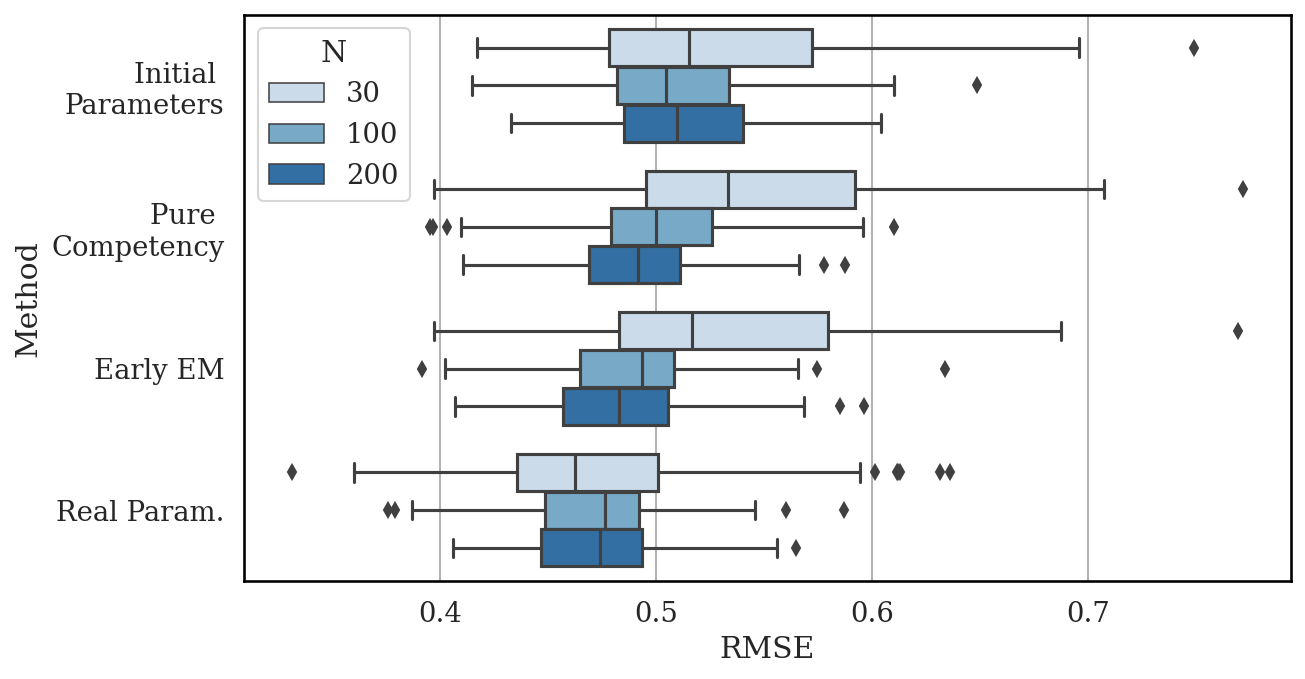

In [184]:
model_boxplot(full_Q_df, metric="rmse_theta", methods=["late_em", "initial", "real_parameters", "pure_competency"], title="")
plt.savefig("results/plots/boxplot_full_Q_rmse_theta.png", bbox_inches="tight", dpi=250)

# Results

In [14]:
full_Q_df = pd.read_csv("results/full_q.csv")
print("Full Q sample size: {0}".format(full_Q_df.shape[0]))
sep_Q_df = pd.read_csv("results/seperated_q.csv")
print("Seperated Q sample size: {0}".format(sep_Q_df.shape[0]))
pyramid_Q_df = pd.read_csv("results/pyramid_q.csv")
print("Pyramid Q sample size: {0}".format(pyramid_Q_df.shape[0]))

Full Q sample size: 10800
Seperated Q sample size: 10800
Pyramid Q sample size: 10800


## Simulatuion Results

### Model Fit

In [15]:
single_metric_table(full_Q_df, metric="late_l_estimated")

\begin{table}[H]
\centering
\caption{, $n=100$}
\begin{tabular}{llllllll}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &         10 &         20 &         30 &         10 &         20 &         30 \\
\textbf{N} & {} &            &            &            &            &            &            \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Initial Parameters} &    -245.42 &    -395.67 &   -544.735 &    -296.77 &    -453.19 &   -627.175 \\
    & \textbf{Difference} &   -190.435 &   -303.115 &     -409.7 &    -218.12 &   -324.185 &   -435.525 \\
    & \textbf{Pure Competency} &   -191.675 &    -300.72 &   -411.445 &   -218.025 &   -316.655 &    -422.56 \\
    & \textbf{Late EM} &    -186.49 &    -299.48 &     -410.5 &   -206.905 &    -313.99 &   -427.705 \\
    & \textbf{Real early Param.} &    -197.43 &   -297.495 &   -412.505 &   -226.725 &   -323.895 &    -422.55 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3796\3497693500.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension                2                                3             \
Item Dimension                 10         20         30         10         20   
N                                                                               
30  Initial Parameters    -245.42    -395.67   -544.735    -296.77    -453.19   
    Difference           -190.435   -303.115     -409.7    -218.12   -324.185   
    Pure Competency      -191.675    -300.72   -411.445   -218.025   -316.655   
    Late EM               -186.49    -299.48     -410.5   -206.905    -313.99   
    Real early Param.     -197.43   -297.495   -412.505   -226.725   -323.895   
100 Initial Parameters    -860.21   -1344.75   -1844.41   -968.195  -1572.455   
    Difference           -682.975  -1076.375  -1491.725   -731.745  -1136.265   
    Pure Competency      -670.645   -1067.45  -1501.545    -745.03  -1119.305   
    Late EM               -659.38  -1072.655   -1496.78    -710.57   -1107.84   
    Real early Param.     -685.79  -1074.105  -1492.915   -784.065  -1135.415   
200 Initial Parameters   -1643.76   -2695.04   -3664.93   -1995.71  -3133.465   
    Difference           -1325.62  -2152.105   -2922.69  -1510.115   -2299.51   
    Pure Competency     -1317.375  -2117.375   -2916.78   -1525.74  -2274.195   
    Late EM             -1282.755   -2111.61   -2916.27   -1454.48   -2247.94   
    Real early Param.   -1356.445  -2144.485  -2945.335    -1604.4   -2313.44   

Latent Dimension                   
Item Dimension                 30  
N                                  
30  Initial Parameters   -627.175  
    Difference           -435.525  
    Pure Competency       -422.56  
    Late EM              -427.705  
    Real early Param.     -422.55  
100 Initial Parameters   -2051.23  
    Difference          -1524.095  
    Pure Competency     -1495.725  
    Late EM              -1492.61  
    Real early Param.    -1506.78  
200 Initial Parameters  -4233.995  
    Difference           -3093.71  
    Pure Competency       -3047.1  
    Late EM             -3036.145  
    Real early Param.   -3048.585

In [16]:
likelihood_table_model(df_list=[full_Q_df, sep_Q_df, pyramid_Q_df], caption="Median Marginal Log-Likelihood, $D=2$, $J=20$")

\begin{table}[H]
\centering
\caption{Median Marginal Log-Likelihood, $D=2$, $J=20$, $n=100$}
\begin{tabular}{llllllll}
\toprule
    & \textbf{Model} & \multicolumn{3}{l}{Early} & \multicolumn{3}{l}{Late} \\
    & \textbf{Q-type} &   Full & Pyramid & Separated &   Full & Pyramid & Separated \\
\textbf{N} & {} &        &         &           &        &         &           \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Initial Parameters} &   -319 &    -306 &      -331 &   -395 &    -360 &      -441 \\
    & \textbf{Difference} &   -291 &    -280 &      -313 &   -303 &    -288 &      -338 \\
    & \textbf{Pure Competency} &   -292 &    -280 &      -313 &   -301 &    -291 &      -328 \\
    & \textbf{Late EM} &   -291 &    -279 &      -312 &   -299 &    -289 &      -331 \\
    & \textbf{Real early Param.} &        &         &           &   -297 &    -291 &      -332 \\
    & \textbf{Real Param.} &   -319 &    -308 &      -336 &   -327 &    -316 &      -352 \\
\cline{1-8}
\multirow{6}{*

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3796\1641387634.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fit_table.to_latex(bold_rows=True, multirow=True,


Model                   Early                     Late                  
Q-type                   Full Pyramid Separated   Full Pyramid Separated
N                                                                       
30  Initial Parameters   -319    -306      -331   -395    -360      -441
    Difference           -291    -280      -313   -303    -288      -338
    Pure Competency      -292    -280      -313   -301    -291      -328
    Late EM              -291    -279      -312   -299    -289      -331
    Real early Param.                             -297    -291      -332
    Real Param.          -319    -308      -336   -327    -316      -352
100 Initial Parameters  -1078   -1047     -1122  -1345   -1252     -1493
    Difference          -1038   -1004     -1087  -1076   -1011     -1156
    Pure Competency     -1038   -1003     -1096  -1067   -1025     -1128
    Late EM             -1038   -1002     -1087  -1072   -1016     -1130
    Real early Param.                            -1074   -1024     -1133
    Real Param.         -1074   -1026     -1112  -1100   -1050     -1160
200 Initial Parameters  -2158   -2096     -2256  -2695   -2419     -3088
    Difference          -2087   -2028     -2194  -2152   -2007     -2400
    Pure Competency     -2096   -2032     -2205  -2117   -2038     -2353
    Late EM             -2088   -2029     -2192  -2111   -2003     -2360
    Real early Param.                            -2144   -2062     -2385
    Real Param.         -2116   -2059     -2217  -2178   -2059     -2402

### Full Q Matrix

In [26]:
parameter_table_model(full_Q_df, caption="Full Q-Matrix, Parameter estimation Median RMSE, $D=2$, $J=20$")

\begin{table}[H]
\centering
\caption{Full Q-Matrix, Parameter estimation Median RMSE, $D=2$, $J=20$, $n=100$}
\begin{tabular}{lllllllll}
\toprule
    &                   &     $A$ & $\Delta$ & $\Sigma^{\theta}$ &   $A^l$ & $\Delta^l$ & $\Sigma^s$ & $\Psi$ \\
\textbf{N} & {} &         &          &                   &         &            &            &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Initial Parameters} &   0.582 &    0.536 &             0.148 &   0.808 &      1.487 &      0.442 &   0.34 \\
    & \textbf{Difference} &   1.346 &     1.16 &             0.081 &   2.321 &       2.34 &      0.22* &  0.262 \\
    & \textbf{Pure Competency} &   1.331 &    1.162 &             0.206 &   3.939 &      3.509 &      0.275 &   0.27 \\
    & \textbf{Late EM} &   1.389 &    1.212 &              0.08 &   3.632 &      3.198 &     0.189* &  0.282 \\
    & \textbf{Real early Param.} &     0.0 &      0.0 &               0.0 &   3.326 &      3.226 &     0.173* &  0.309 \\
\cline{1-

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3796\3059667431.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A$ $\Delta$ $\Sigma^{\theta}$   $A^l$ $\Delta^l$  \
N                                                                              
30  Initial Parameters   0.582    0.536             0.148   0.808      1.487   
    Difference           1.346     1.16             0.081   2.321       2.34   
    Pure Competency      1.331    1.162             0.206   3.939      3.509   
    Late EM              1.389    1.212              0.08   3.632      3.198   
    Real early Param.      0.0      0.0               0.0   3.326      3.226   
100 Initial Parameters   0.576     0.42             0.119   0.811      1.394   
    Difference           0.42*    0.376             0.067  0.523*     0.691*   
    Pure Competency     0.413*     0.37             0.236   0.611      0.945   
    Late EM             0.419*    0.371              0.06   0.622     0.776*   
    Real early Param.      0.0      0.0               0.0   0.565     0.733*   
200 Initial Parameters   0.597    0.389             0.139   0.831      1.378   
    Difference          0.318*   0.256*             0.075   0.38*     0.443*   
    Pure Competency       0.3*   0.263*             0.214  0.416*     0.707*   
    Late EM              0.31*   0.262*             0.083  0.448*     0.591*   
    Real early Param.      0.0      0.0               0.0  0.418*     0.548*   

                       $\Sigma^s$ $\Psi$  
N                                         
30  Initial Parameters      0.442   0.34  
    Difference              0.22*  0.262  
    Pure Competency         0.275   0.27  
    Late EM                0.189*  0.282  
    Real early Param.      0.173*  0.309  
100 Initial Parameters      0.403  0.356  
    Difference             0.142*  0.227  
    Pure Competency         0.249  0.286  
    Late EM                  0.19  0.311  
    Real early Param.        0.18  0.313  
200 Initial Parameters      0.396  0.335  
    Difference             0.146*  0.203  
    Pure Competency         0.278  0.256  
    Late EM                0.209*  0.303  
    Real early Param.      0.172*  0.298

In [34]:
single_metric_table(full_Q_df, "rmse_psi", caption="Full Q-Matrix, Median RMSE for $\Psi$")

\begin{table}[H]
\centering
\caption{Full Q-Matrix, Median RMSE for $\Psi$, $n=100$}
\begin{tabular}{llllllll}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &      30 &     10 &      20 &      30 \\
\textbf{N} & {} &        &        &         &        &         &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Initial Parameters} &  0.339 &   0.34 &   0.352 &  0.343 &   0.327 &   0.327 \\
    & \textbf{Difference} &  0.312 &  0.262 &   0.219 &  0.325 &   0.293 &   0.264 \\
    & \textbf{Pure Competency} &   0.26 &   0.27 &   0.271 &  0.285 &   0.285 &   0.295 \\
    & \textbf{Late EM} &  0.297 &  0.282 &   0.285 &  0.312 &   0.342 &   0.343 \\
    & \textbf{Real early Param.} &   0.31 &  0.309 &   0.302 &  0.337 &   0.359 &    0.35 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Initial Parameters} &  0.331 &  0.356 &   0.354 &  0.325 &   0.328 &   0.332 \\
    & \textbf{Dif

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3796\3497693500.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension            2                     3                
Item Dimension             10     20      30     10      20      30
N                                                                  
30  Initial Parameters  0.339   0.34   0.352  0.343   0.327   0.327
    Difference          0.312  0.262   0.219  0.325   0.293   0.264
    Pure Competency      0.26   0.27   0.271  0.285   0.285   0.295
    Late EM             0.297  0.282   0.285  0.312   0.342   0.343
    Real early Param.    0.31  0.309   0.302  0.337   0.359    0.35
100 Initial Parameters  0.331  0.356   0.354  0.325   0.328   0.332
    Difference          0.278  0.227  0.167*  0.295   0.24*  0.219*
    Pure Competency     0.255  0.286   0.288  0.294   0.294    0.29
    Late EM             0.274  0.311    0.31  0.309    0.33   0.328
    Real early Param.   0.291  0.313   0.311  0.333   0.346    0.34
200 Initial Parameters  0.326  0.335   0.338  0.317   0.327    0.34
    Difference          0.273  0.203  0.162*  0.277  0.234*  0.199*
    Pure Competency      0.26  0.256   0.277   0.29   0.272   0.297
    Late EM             0.302  0.303   0.342  0.306   0.327   0.329
    Real early Param.   0.303  0.298   0.334  0.327   0.326   0.333

In [33]:
single_metric_table(full_Q_df, "rmse_late_sigma", caption="Full Q-Matrix, Median RMSE for $\Sigma^{s}$")

\begin{table}[H]
\centering
\caption{Full Q-Matrix, Median RMSE for $\Sigma^{s}$, $n=100$}
\begin{tabular}{llllllll}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &      10 &      20 &      30 &      10 &      20 &      30 \\
\textbf{N} & {} &         &         &         &         &         &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Initial Parameters} &   0.378 &   0.442 &   0.422 &   0.391 &    0.41 &   0.413 \\
    & \textbf{Difference} &   0.222 &   0.22* &   0.212 &  0.257* &   0.246 &   0.233 \\
    & \textbf{Pure Competency} &   0.254 &   0.275 &   0.243 &   0.316 &   0.296 &   0.311 \\
    & \textbf{Late EM} &   0.243 &  0.189* &  0.195* &   0.277 &  0.249* &  0.256* \\
    & \textbf{Real early Param.} &  0.202* &  0.173* &  0.169* &  0.247* &  0.222* &  0.229* \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Initial Parameters} &   0.388 &   0.403 &   0.356 &   0.375 &   0.354 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3796\3497693500.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension             2                       3                
Item Dimension              10      20      30      10      20      30
N                                                                     
30  Initial Parameters   0.378   0.442   0.422   0.391    0.41   0.413
    Difference           0.222   0.22*   0.212  0.257*   0.246   0.233
    Pure Competency      0.254   0.275   0.243   0.316   0.296   0.311
    Late EM              0.243  0.189*  0.195*   0.277  0.249*  0.256*
    Real early Param.   0.202*  0.173*  0.169*  0.247*  0.222*  0.229*
100 Initial Parameters   0.388   0.403   0.356   0.375   0.354   0.407
    Difference          0.152*  0.142*  0.175*  0.212*  0.176*  0.183*
    Pure Competency      0.254   0.249   0.257   0.301   0.296   0.316
    Late EM              0.21*    0.19    0.18   0.284   0.248  0.258*
    Real early Param.   0.156*    0.18  0.167*   0.23*  0.211*  0.245*
200 Initial Parameters   0.384   0.396   0.377   0.394    0.39   0.398
    Difference          0.168*  0.146*  0.155*  0.215*  0.154*  0.145*
    Pure Competency      0.257   0.278   0.233   0.324   0.293   0.289
    Late EM               0.24  0.209*  0.176*  0.288*  0.246*   0.251
    Real early Param.   0.168*  0.172*  0.148*  0.233*  0.231*  0.226*

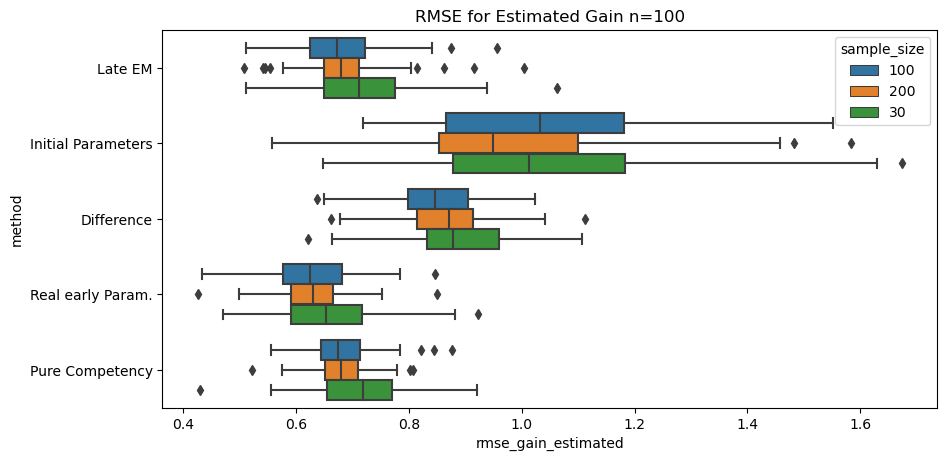

In [100]:
model_boxplot(full_Q_df, metric='rmse_gain_estimated', title="RMSE for Estimated Gain")

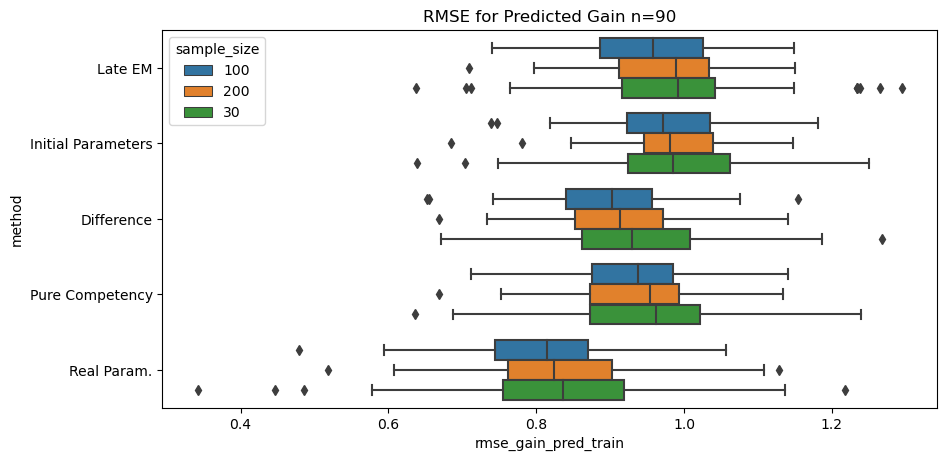

In [13]:
model_boxplot(full_Q_df, metric='rmse_gain_pred_train', title="RMSE for Predicted Gain", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency"])

### Separated Q-Matrix

In [31]:
parameter_table_model(sep_Q_df, caption="Separated Q-Matrix, Parameter estimation Median RMSE $D=2$, $J=20$")

\begin{table}[H]
\centering
\caption{Separated Q-Matrix, Parameter estimation Median RMSE $D=2$, $J=20$, $n=100$}
\begin{tabular}{lllllllll}
\toprule
    &                   &     $A$ & $\Delta$ & $\Sigma^{\theta}$ &   $A^l$ & $\Delta^l$ & $\Sigma^s$ & $\Psi$ \\
\textbf{N} & {} &         &          &                   &         &            &            &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Initial Parameters} &   0.449 &    0.481 &             0.153 &   0.868 &      1.255 &      0.392 &   0.35 \\
    & \textbf{Difference} &   0.868 &    0.891 &             0.102 &   1.135 &      1.335 &      0.244 &  0.253 \\
    & \textbf{Pure Competency} &   0.853 &    0.882 &               0.2 &   1.674 &      1.996 &      0.249 &  0.281 \\
    & \textbf{Late EM} &   0.873 &    0.862 &             0.103 &   1.413 &      1.508 &       0.2* &  0.351 \\
    & \textbf{Real early Param.} &     0.0 &      0.0 &               0.0 &   1.448 &      1.582 &      0.19* &   0.35 \\
\clin

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3796\3059667431.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A$ $\Delta$ $\Sigma^{\theta}$   $A^l$ $\Delta^l$  \
N                                                                              
30  Initial Parameters   0.449    0.481             0.153   0.868      1.255   
    Difference           0.868    0.891             0.102   1.135      1.335   
    Pure Competency      0.853    0.882               0.2   1.674      1.996   
    Late EM              0.873    0.862             0.103   1.413      1.508   
    Real early Param.      0.0      0.0               0.0   1.448      1.582   
100 Initial Parameters   0.473    0.368             0.114   0.856      1.223   
    Difference          0.307*    0.344             0.056   0.34*     0.532*   
    Pure Competency       0.3*     0.34             0.249  0.394*     0.815*   
    Late EM             0.309*    0.343             0.056  0.401*     0.738*   
    Real early Param.      0.0      0.0               0.0  0.376*     0.618*   
200 Initial Parameters   0.489    0.322             0.126   0.869      1.205   
    Difference          0.214*   0.232*             0.041  0.255*     0.343*   
    Pure Competency     0.227*   0.232*             0.227   0.26*     0.695*   
    Late EM             0.227*   0.233*             0.038  0.279*     0.645*   
    Real early Param.      0.0      0.0               0.0  0.258*     0.524*   

                       $\Sigma^s$ $\Psi$  
N                                         
30  Initial Parameters      0.392   0.35  
    Difference              0.244  0.253  
    Pure Competency         0.249  0.281  
    Late EM                  0.2*  0.351  
    Real early Param.       0.19*   0.35  
100 Initial Parameters      0.374  0.313  
    Difference             0.152*  0.193  
    Pure Competency         0.237  0.253  
    Late EM                0.203*  0.296  
    Real early Param.      0.183*  0.302  
200 Initial Parameters      0.367  0.328  
    Difference             0.137*   0.2*  
    Pure Competency          0.24  0.283  
    Late EM                 0.191  0.296  
    Real early Param.      0.173*  0.294

In [15]:
single_metric_table(sep_Q_df, "rmse_psi", caption="Seperated Q-Matrix RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{Seperated Q-Matrix RMSE for Correlations $\Psi$, $n=46$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.295 &  0.250 &  0.210 &  0.317 &  0.265 &  0.231 \\
    & \textbf{Initial Parameters} &  0.322 &  0.342 &  0.364 &  0.307 &  0.338 &  0.314 \\
    & \textbf{Late EM} &  0.285 &  0.355 &  0.308 &  0.310 &  0.355 &  0.352 \\
    & \textbf{Pure Competency} &  0.242 &  0.277 &  0.288 &  0.275 &  0.294 &  0.284 \\
    & \textbf{Real early Param.} &  0.265 &  0.369 &  0.292 &  0.331 &  0.359 &  0.359 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.244 &  0.193 &  0.162 &  0.300 &  0.227 &  0.193 \\
    & \textbf{Initial Param

Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.295  0.250  0.210  0.317  0.265  0.231
    Initial Parameters  0.322  0.342  0.364  0.307  0.338  0.314
    Late EM             0.285  0.355  0.308  0.310  0.355  0.352
    Pure Competency     0.242  0.277  0.288  0.275  0.294  0.284
    Real early Param.   0.265  0.369  0.292  0.331  0.359  0.359
100 Difference          0.244  0.193  0.162  0.300  0.227  0.193
    Initial Parameters  0.327  0.331  0.357  0.337  0.352  0.336
    Late EM             0.299  0.323  0.295  0.316  0.324  0.358
    Pure Competency     0.252  0.250  0.262  0.308  0.313  0.309
    Real early Param.   0.300  0.322  0.302  0.357  0.365  0.350
200 Difference          0.299  0.218  0.151  0.290  0.221  0.181
    Initial Parameters  0.375  0.340  0.352  0.321  0.336  0.331
    Late EM             0.321  0.298  0.290  0.317  0.319  0.363
    Pure Competency     0.304  0.303  0.291  0.291  0.284  0.301
    Real early Param.   0.327  0.296  0.301  0.333  0.341  0.367

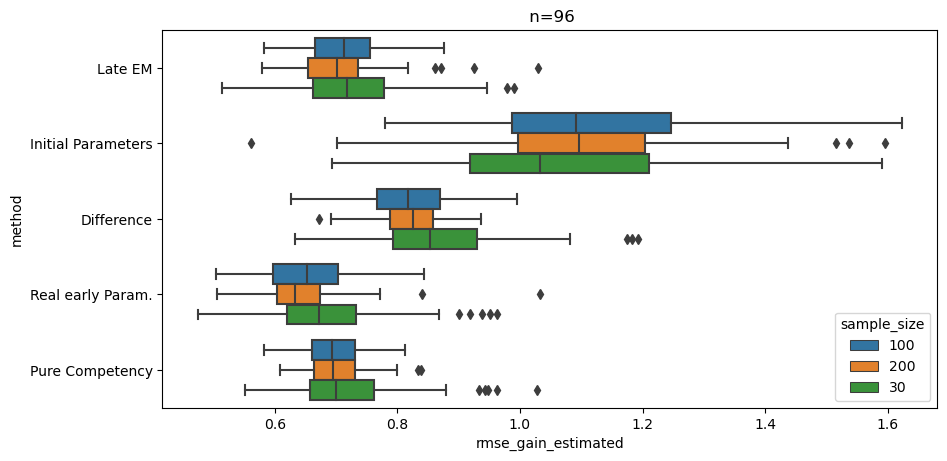

In [16]:
model_boxplot(sep_Q_df, metric='rmse_gain_estimated')

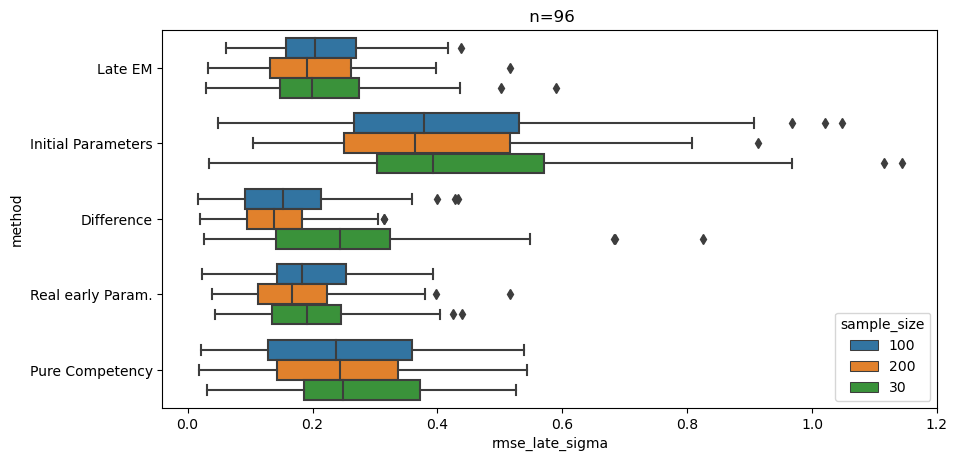

In [18]:
model_boxplot(sep_Q_df, metric='rmse_late_sigma')

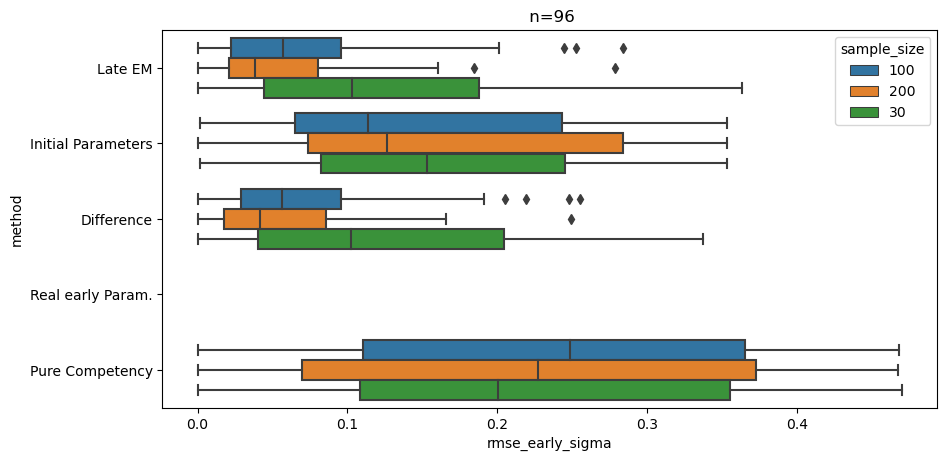

In [17]:
model_boxplot(sep_Q_df, metric='rmse_early_sigma')

### Pyramid Q-Matrix

In [30]:
parameter_table_model(full_Q_df, caption="Pyramid Q-Matrix, Parameter estimation Median RMSE $D=2$, $J=20$")

\begin{table}[H]
\centering
\caption{Pyramid Q-Matrix, Parameter estimation Median RMSE $D=2$, $J=20$, $n=100$}
\begin{tabular}{lllllllll}
\toprule
    &                   &     $A$ & $\Delta$ & $\Sigma^{\theta}$ &   $A^l$ & $\Delta^l$ & $\Sigma^s$ & $\Psi$ \\
\textbf{N} & {} &         &          &                   &         &            &            &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Initial Parameters} &   0.582 &    0.536 &             0.148 &   0.808 &      1.487 &      0.442 &   0.34 \\
    & \textbf{Difference} &   1.346 &     1.16 &             0.081 &   2.321 &       2.34 &      0.22* &  0.262 \\
    & \textbf{Pure Competency} &   1.331 &    1.162 &             0.206 &   3.939 &      3.509 &      0.275 &   0.27 \\
    & \textbf{Late EM} &   1.389 &    1.212 &              0.08 &   3.632 &      3.198 &     0.189* &  0.282 \\
    & \textbf{Real early Param.} &     0.0 &      0.0 &               0.0 &   3.326 &      3.226 &     0.173* &  0.309 \\
\cline{

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3796\3059667431.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A$ $\Delta$ $\Sigma^{\theta}$   $A^l$ $\Delta^l$  \
N                                                                              
30  Initial Parameters   0.582    0.536             0.148   0.808      1.487   
    Difference           1.346     1.16             0.081   2.321       2.34   
    Pure Competency      1.331    1.162             0.206   3.939      3.509   
    Late EM              1.389    1.212              0.08   3.632      3.198   
    Real early Param.      0.0      0.0               0.0   3.326      3.226   
100 Initial Parameters   0.576     0.42             0.119   0.811      1.394   
    Difference           0.42*    0.376             0.067  0.523*     0.691*   
    Pure Competency     0.413*     0.37             0.236   0.611      0.945   
    Late EM             0.419*    0.371              0.06   0.622     0.776*   
    Real early Param.      0.0      0.0               0.0   0.565     0.733*   
200 Initial Parameters   0.597    0.389             0.139   0.831      1.378   
    Difference          0.318*   0.256*             0.075   0.38*     0.443*   
    Pure Competency       0.3*   0.263*             0.214  0.416*     0.707*   
    Late EM              0.31*   0.262*             0.083  0.448*     0.591*   
    Real early Param.      0.0      0.0               0.0  0.418*     0.548*   

                       $\Sigma^s$ $\Psi$  
N                                         
30  Initial Parameters      0.442   0.34  
    Difference              0.22*  0.262  
    Pure Competency         0.275   0.27  
    Late EM                0.189*  0.282  
    Real early Param.      0.173*  0.309  
100 Initial Parameters      0.403  0.356  
    Difference             0.142*  0.227  
    Pure Competency         0.249  0.286  
    Late EM                  0.19  0.311  
    Real early Param.        0.18  0.313  
200 Initial Parameters      0.396  0.335  
    Difference             0.146*  0.203  
    Pure Competency         0.278  0.256  
    Late EM                0.209*  0.303  
    Real early Param.      0.172*  0.298

In [20]:
single_metric_table(pyramid_Q_df, "rmse_psi", caption="Pyramid Q-Matrix, Median RMSE for $\Psi$")

\begin{table}[H]
\centering
\caption{Pyramid Q-Matrix, Median RMSE for $\Psi$, $n=21$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.279 &  0.311 &  0.237 &  0.324 &  0.318 &  0.327 \\
    & \textbf{Initial Parameters} &  0.344 &  0.367 &  0.349 &  0.298 &  0.338 &  0.360 \\
    & \textbf{Late EM} &  0.292 &  0.308 &  0.302 &  0.302 &  0.334 &  0.315 \\
    & \textbf{Pure Competency} &  0.237 &  0.289 &  0.243 &  0.269 &  0.303 &  0.286 \\
    & \textbf{Real early Param.} &  0.305 &  0.341 &  0.315 &  0.320 &  0.358 &  0.329 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.300 &  0.233 &  0.225 &  0.319 &  0.289 &  0.274 \\
    & \textbf{Initial Parameters} 

Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.279  0.311  0.237  0.324  0.318  0.327
    Initial Parameters  0.344  0.367  0.349  0.298  0.338  0.360
    Late EM             0.292  0.308  0.302  0.302  0.334  0.315
    Pure Competency     0.237  0.289  0.243  0.269  0.303  0.286
    Real early Param.   0.305  0.341  0.315  0.320  0.358  0.329
100 Difference          0.300  0.233  0.225  0.319  0.289  0.274
    Initial Parameters  0.346  0.320  0.365  0.323  0.330  0.285
    Late EM             0.274  0.310  0.360  0.289  0.300  0.291
    Pure Competency     0.229  0.264  0.263  0.288  0.290  0.273
    Real early Param.   0.296  0.296  0.365  0.331  0.311  0.307
200 Difference          0.323  0.256  0.215  0.307  0.275  0.264
    Initial Parameters  0.335  0.289  0.316  0.308  0.326  0.318
    Late EM             0.303  0.270  0.240  0.290  0.313  0.286
    Pure Competency     0.287  0.234  0.270  0.269  0.294  0.285
    Real early Param.   0.373  0.287  0.241  0.334  0.351  0.319

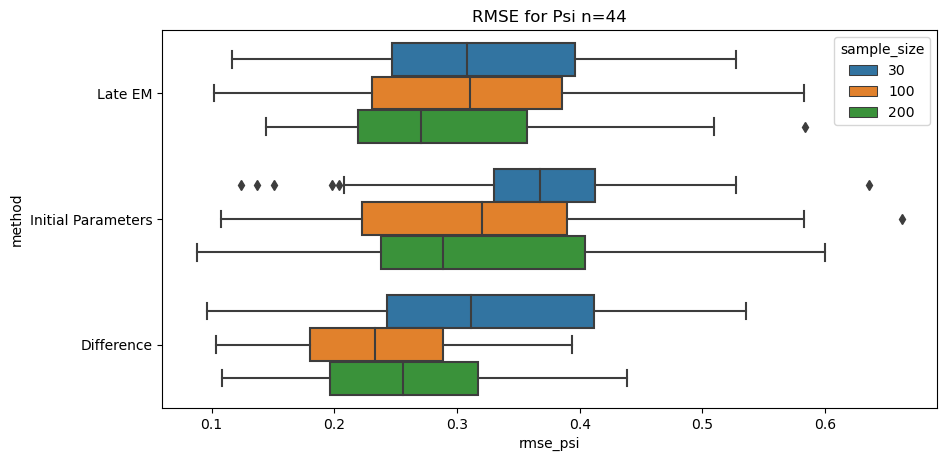

In [21]:
model_boxplot(pyramid_Q_df, metric="rmse_psi", methods=["late_em", "initial", "difference"], title="RMSE for Psi")

## Experiment 2: Prediction of Competency Gain

In [36]:
single_metric_table(full_Q_df, "rmse_theta", caption="Full Q-Matrix, Median RMSE for the estimation of $\\Theta$",
                    methods=["late_em", "initial", "real_parameters", "pure_competency"])

\begin{table}[H]
\centering
\caption{Full Q-Matrix, Median RMSE for the estimation of $\Theta$, $n=100$}
\begin{tabular}{llllllll}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &      30 &     10 &      20 &      30 \\
\textbf{N} & {} &        &        &         &        &         &         \\
\midrule
\multirow{4}{*}{\textbf{30 }} & \textbf{Initial Parameters} &  0.593 &  0.515 &   0.468 &  0.667 &   0.579 &   0.526 \\
    & \textbf{Pure Competency} &  0.657 &  0.533 &   0.498 &  0.693 &    0.61 &   0.558 \\
    & \textbf{Late EM} &  0.625 &  0.517 &   0.485 &  0.677 &   0.587 &   0.547 \\
    & \textbf{Real Param.} &  0.577 &  0.462 &   0.414 &  0.618 &   0.522 &   0.466 \\
\cline{1-8}
\multirow{4}{*}{\textbf{100}} & \textbf{Initial Parameters} &  0.616 &  0.505 &    0.45 &  0.671 &   0.566 &   0.514 \\
    & \textbf{Pure Competency} &  0.614 &    0.5 &    0.44 &   0.68 &   0.563 &   0.506 \

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3796\3497693500.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension            2                     3                
Item Dimension             10     20      30     10      20      30
N                                                                  
30  Initial Parameters  0.593  0.515   0.468  0.667   0.579   0.526
    Pure Competency     0.657  0.533   0.498  0.693    0.61   0.558
    Late EM             0.625  0.517   0.485  0.677   0.587   0.547
    Real Param.         0.577  0.462   0.414  0.618   0.522   0.466
100 Initial Parameters  0.616  0.505    0.45  0.671   0.566   0.514
    Pure Competency     0.614    0.5    0.44   0.68   0.563   0.506
    Late EM             0.601  0.493   0.432  0.661   0.545   0.488
    Real Param.         0.581  0.476   0.413  0.639  0.522*   0.47*
200 Initial Parameters   0.61   0.51   0.449  0.666   0.567    0.51
    Pure Competency     0.608  0.492   0.433  0.674   0.553   0.492
    Late EM             0.597  0.483   0.422  0.655   0.537  0.478*
    Real Param.         0.581  0.474  0.412*  0.635  0.523*  0.467*

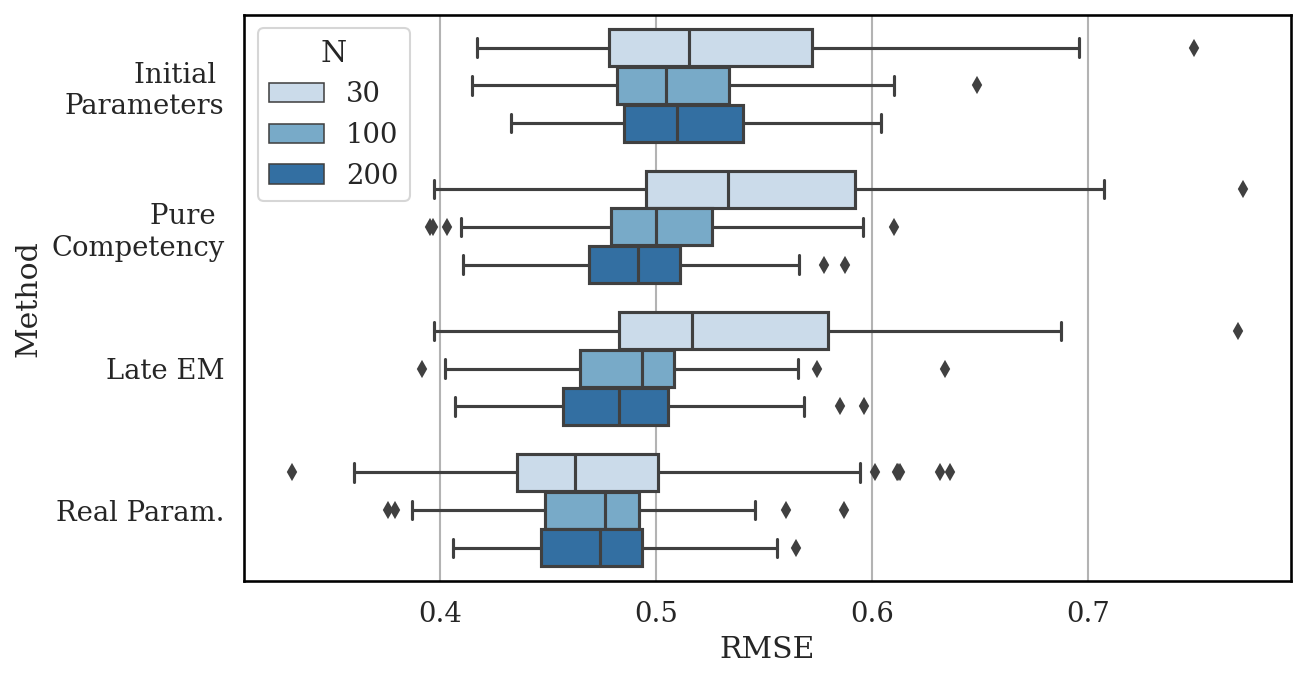

In [186]:
model_boxplot(full_Q_df, metric="rmse_theta", methods=["late_em", "initial", "real_parameters", "pure_competency"], title="")
plt.savefig("results/plots/boxplot_full_Q_rmse_theta.png", bbox_inches="tight", dpi=250)

In [190]:
single_metric_table(full_Q_df, "rmse_gain_estimated", caption="Full Q-Matrix, Median RMSE for competency gain estimation, $D=2$, $J=20$",
                        methods=["late_em", "initial", "difference", "real_early", "real_parameters", "pure_competency"])

\begin{table}[H]
\centering
\caption{Full Q-Matrix, Median RMSE for competency gain estimation, $D=2$, $J=20$, $n=100$}
\begin{tabular}{llllllll}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &      10 &      20 &      30 &      10 &      20 &      30 \\
\textbf{N} & {} &         &         &         &         &         &         \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Initial Parameters} &   0.927 &   1.013 &   1.069 &   1.006 &   1.111 &   1.168 \\
    & \textbf{Difference} &   0.885 &   0.877 &    0.87 &   0.964 &   0.976 &   0.974 \\
    & \textbf{Pure Competency} &   0.779 &  0.718* &  0.678* &   0.846 &  0.775* &   0.75* \\
    & \textbf{Late EM} &    0.78 &  0.712* &  0.648* &   0.857 &   0.77* &  0.736* \\
    & \textbf{Real early Param.} &  0.764* &  0.653* &  0.604* &   0.851 &  0.748* &   0.71* \\
    & \textbf{Real Param.} &   0.56* &  0.484* &  0.432* &  0.616* &  0.531* &  0.485* \\
\cl

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3796\3497693500.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension             2                       3                
Item Dimension              10      20      30      10      20      30
N                                                                     
30  Initial Parameters   0.927   1.013   1.069   1.006   1.111   1.168
    Difference           0.885   0.877    0.87   0.964   0.976   0.974
    Pure Competency      0.779  0.718*  0.678*   0.846  0.775*   0.75*
    Late EM               0.78  0.712*  0.648*   0.857   0.77*  0.736*
    Real early Param.   0.764*  0.653*  0.604*   0.851  0.748*   0.71*
    Real Param.          0.56*  0.484*  0.432*  0.616*  0.531*  0.485*
100 Initial Parameters   0.911   1.032   1.037   0.992   1.034   1.206
    Difference           0.891   0.847  0.854*   0.938   0.952  0.949*
    Pure Competency      0.78*  0.674*  0.624*  0.835*  0.741*  0.698*
    Late EM             0.795*  0.672*  0.613*  0.857*  0.761*  0.701*
    Real early Param.   0.743*  0.625*  0.562*  0.831*   0.73*  0.661*
    Real Param.         0.568*  0.478*  0.434*  0.622*   0.54*  0.487*
200 Initial Parameters    0.93    0.95   1.065   0.997   1.091   1.178
    Difference           0.872    0.87  0.861*    0.95   0.943   0.95*
    Pure Competency      0.76*   0.68*  0.626*  0.842*  0.739*  0.691*
    Late EM             0.772*   0.68*  0.635*  0.857*  0.758*  0.686*
    Real early Param.   0.737*   0.63*   0.58*  0.832*  0.723*  0.657*
    Real Param.         0.578*  0.498*   0.45*  0.613*  0.535*  0.489*

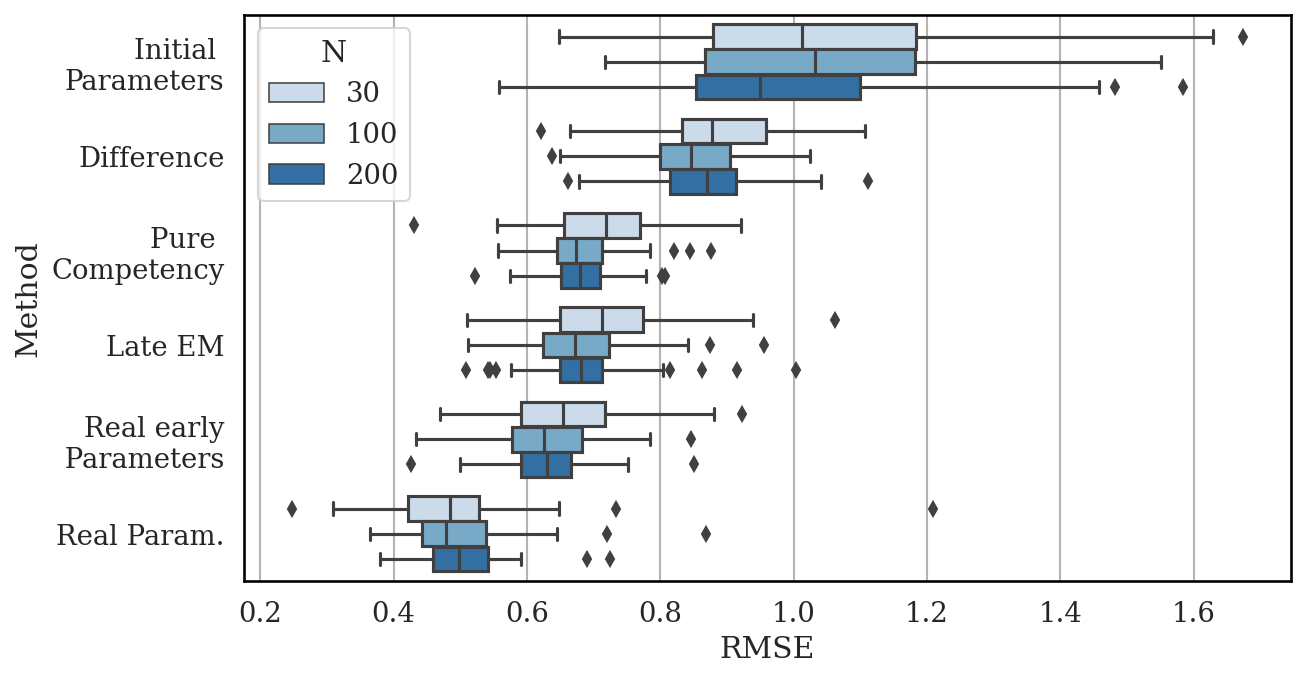

In [187]:
model_boxplot(full_Q_df, metric="rmse_gain_estimated", title="", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_estimated.png", bbox_inches="tight", dpi=250)

In [191]:
single_metric_table(full_Q_df, "rmse_gain_pred_train", caption="Full Q-Matrix, Median RMSE competency gain prediction, $D=2$, $J=20$",
                    methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])

\begin{table}[H]
\centering
\caption{Full Q-Matrix, Median RMSE competency gain prediction, $D=2$, $J=20$, $n=100$}
\begin{tabular}{llllllll}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &      10 &      20 &      30 &      10 &      20 &      30 \\
\textbf{N} & {} &         &         &         &         &         &         \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Initial Parameters} &   0.975 &   0.985 &   0.961 &    1.03 &   1.032 &   1.047 \\
    & \textbf{Difference} &   0.953 &   0.928 &   0.899 &   1.037 &   1.007 &   0.983 \\
    & \textbf{Pure Competency} &   0.952 &   0.951 &   0.927 &   1.004 &   1.006 &   1.017 \\
    & \textbf{Late EM} &   0.971 &   0.987 &   0.953 &   1.031 &   1.061 &    1.05 \\
    & \textbf{Real early Param.} &   0.982 &   0.981 &   0.957 &   1.045 &   1.058 &   1.052 \\
    & \textbf{Real Param.} &   0.815 &  0.832* &   0.802 &  0.854* &  0.846* &  0.851* \\
\cline{

C:\Users\Jesper\AppData\Local\Temp\ipykernel_3796\3497693500.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,


Latent Dimension             2                       3                
Item Dimension              10      20      30      10      20      30
N                                                                     
30  Initial Parameters   0.975   0.985   0.961    1.03   1.032   1.047
    Difference           0.953   0.928   0.899   1.037   1.007   0.983
    Pure Competency      0.952   0.951   0.927   1.004   1.006   1.017
    Late EM              0.971   0.987   0.953   1.031   1.061    1.05
    Real early Param.    0.982   0.981   0.957   1.045   1.058   1.052
    Real Param.          0.815  0.832*   0.802  0.854*  0.846*  0.851*
100 Initial Parameters   0.993   0.973   0.979   1.052   1.042   1.054
    Difference           0.947   0.904    0.88   1.023   0.989  0.958*
    Pure Competency       0.96   0.939   0.938   1.022    1.02   1.018
    Late EM              0.989   0.958   0.973   1.042   1.051   1.045
    Real early Param.    0.969    0.95   0.957   1.062    1.07   1.051
    Real Param.         0.853*  0.816*  0.814*  0.843*  0.863*  0.841*
200 Initial Parameters   0.975   0.984   0.967   1.055   1.046   1.059
    Difference           0.941   0.914   0.869   1.033   0.994   0.962
    Pure Competency      0.942   0.957   0.924   1.036   1.024   1.022
    Late EM               0.96    0.99    0.96    1.05    1.06   1.054
    Real early Param.    0.965   0.977   0.947   1.065   1.061   1.063
    Real Param.         0.824*  0.824*  0.817*  0.883*  0.868*  0.864*

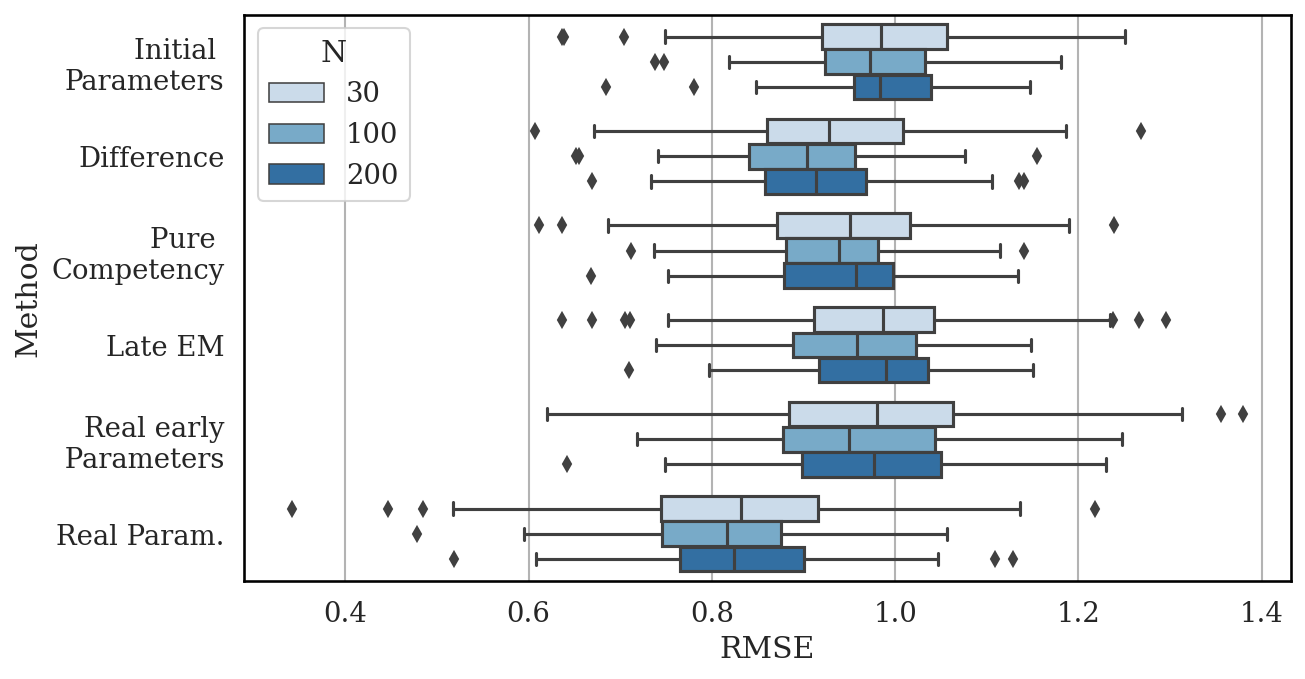

In [188]:
model_boxplot(full_Q_df, metric="rmse_gain_pred_train", title="",
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_predicted.png", bbox_inches="tight", dpi=250)

## CSEDM Data
base: uirt_lfa_model_csedm_final.ipynb

### Read in and preprocess data

In [28]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import time
import os
from os import path
import sys
sys.path.append(os.path.realpath("./models"))
sys.path.append(os.path.realpath("./em_algorithm"))
# Custom modules, import violates pep8, so we have to declare an exeption
if True:  # noqa: E402
    from mirt_2pl import mirt_2pl
    from mirt_2pl_gain import mirt_2pl_gain
    from e_step_mirt_2pl import e_step_ga_mml
    from e_step_mirt_2pl_gain import e_step_ga_mml_gain
    from m_step_mirt_2pl import m_step_ga_mml
    from m_step_mirt_2pl_gain import m_step_ga_mml_gain
    from em_algorithm import em_algo

In [29]:
semester = 'F19'
# BASE_PATH = os.path.join('C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
BASE_PATH = os.path.join('C:/Users/Gerha/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')

In [30]:
#Dataset for early Problem Performance (Aggregated from Event-Data)
early = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early["alt_Label"] = early.apply(lambda x: 1 if (x["CorrectEventually"] and x["Attempts"] <= 3) else 0, axis=1)
early

late = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))

In [31]:
from sklearn.impute import KNNImputer

#Obtain Matrix of Response-vectors
U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
imputer = KNNImputer(n_neighbors=4)
U = imputer.fit_transform(U).round()
U = pd.DataFrame(U)

#Obtain Matrix of Response-vectors
V = pd.crosstab(index = late["SubjectID"], 
            columns=[late["AssignmentID"], late["ProblemID"]], 
            values=late["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#late_U = late_U.dropna()

imputer = KNNImputer(n_neighbors=4)
V = imputer.fit_transform(V).round()
V = pd.DataFrame(V)


In [32]:
V

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
363,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
364,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
365,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [33]:
#Source: https://docs.google.com/spreadsheets/d/1-APxPAVP3PylM0fskzDNgpalj1DTuMqDLkgBC5QxJdg/edit#gid=0
item_skill_df = pd.read_csv("CSEDM Challenge/item_skill_relation.csv")
item_skill_df.columns

Index(['AssignmentID', 'ProblemID', 'Requirement', 'If/Else', 'NestedIf',
       'While', 'For', 'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr',
       'LogicCompareNum', 'LogicBoolean', 'StringFormat', 'StringConcat',
       'StringIndex', 'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex',
       'DefFunction'],
      dtype='object')

In [34]:
logic_skills = ['If/Else', 'NestedIf', 'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean']
string_skills = ['StringFormat', 'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual']
iter_skills = ['While', 'For', 'NestedFor', 'ArrayIndex']

logic_exercises = (np.sum(item_skill_df[logic_skills], axis=1) > 0)
string_exersises = (np.sum(item_skill_df[string_skills], axis=1) > 0)
iter_exercises = (np.sum(item_skill_df[iter_skills], axis=1) > 0)

full_Q = np.stack((logic_exercises, iter_exercises), axis=1)
early_Q = full_Q[0:30,:]
late_Q = full_Q[30:50, :]
# Ensure Identification
late_Q[2,1] = False

In [35]:
late_Q

array([[False,  True],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [False,  True]])

### Fit Model

In [73]:
import random
random.seed(100)
np.random.seed(100)

In [74]:
# Fit early Model
early_model = mirt_2pl(latent_dimension=2, item_dimension=U.shape[1], Q=early_Q)
early_model.initialize_from_responses(response_data=U)
e_step = e_step_ga_mml(model=early_model)
m_step = m_step_ga_mml(
    early_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=early_model)


start_time = time.time()
em.fit([U.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)
theta_hat = early_model.predict_competency(U)
estimated_early_item_parameters = em.model.item_parameters
estimated_early_person_parameters = em.model.person_parameters

EM Iteration 2


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[1.     0.4027]
 [0.4027 1.    ]]
Step: 2: current parameter_diff: 8.206138301834038, current marginal loglikelihood: -5613.803952800157
EM Iteration 3


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[1.     0.3486]
 [0.3486 1.    ]]
Step: 3: current parameter_diff: 4.377151227660264, current marginal loglikelihood: -5595.398596762748
EM Iteration 4
Current Monte Carlo Sample size: 349
[[0.9999 0.3239]
 [0.3239 1.    ]]
Step: 4: current parameter_diff: 1.3175327391583271, current marginal loglikelihood: -5590.271398404762
EM Iteration 5
Current Monte Carlo Sample size: 376
[[1.     0.2897]
 [0.2897 1.    ]]
Step: 5: current parameter_diff: 2.2093959839237955, current marginal loglikelihood: -5587.203587338136
EM Iteration 6
Current Monte Carlo Sample size: 406
[[1.     0.2894]
 [0.2894 1.    ]]
Step: 6: current parameter_diff: 1.5644215991114212, current marginal loglikelihood: -5576.914421972816
EM Iteration 7
Current Monte Carlo Sample size: 438
[[1.     0.2889]
 [0.2889 1.    ]]
Step: 7: current parameter_diff: 0.5395765560027932, current marginal loglikelihood: -5581.662270963657
EM Iteration 8
Current Monte Carlo Sample size: 438
[[0.9999 

In [75]:
p_early = np.mean(U, axis=1)
p_late = np.mean(V, axis=1)
# Correct numerical problems with the inverse logistic function
p_early[p_early == 0] = np.min(p_early[p_early != 0])
p_early[p_early == 1] = np.max(p_early[p_early != 1])
p_late[p_late == 0] = np.min(p_late[p_late != 0])
p_late[p_late == 1] = np.max(p_late[p_late != 1])
# get logits
logit_early = np.log(np.divide(p_early, 1 -
                                p_early))
logit_late = np.log(np.divide(p_late, 1 -
                                p_late))
var_logit_early = np.var(logit_early)
var_logit_late = np.var(logit_late)

#
print("Early logit variance: {0}".format(var_logit_early))
print("Late logit variance: {0}".format(var_logit_late))
print("Approximate convolution variance: {0}".format(var_logit_late/var_logit_early))

Early logit variance: 1.2907867467786318
Late logit variance: 1.790658381505874
Approximate convolution variance: 1.3872612079220314


In [76]:
#Fit late Model
# Initialize Model
late_model = mirt_2pl_gain(item_dimension=20, latent_dimension=2, mu=np.zeros(2),
                            early_sigma=estimated_early_person_parameters["covariance"],
                            Q=late_Q)
# TODO: Check if theta_hat can be used
late_model.initialize_from_responses(
    late_response_data=V, early_response_data=U,
    convolution_variance=np.ones(2)*var_logit_late/var_logit_early,
    sigma=False)
late_initial_parameters = late_model.get_parameters()
e_step = e_step_ga_mml_gain(
    model=late_model, convolution_factor=20, gamma=1.5)
m_step = m_step_ga_mml_gain(
    late_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=late_model)

# Fit late model
start_time = time.time()
em.fit([V, pd.DataFrame(theta_hat)], max_iter=30,
        stop_threshold=0.005, person_method="BFGS")
run_time = (time.time() - start_time)
s_hat = late_model.predict_gain(
    V, pd.DataFrame(theta_hat))

s_pred_train = late_model.predict_gain(
    theta=pd.DataFrame(theta_hat))


EM Iteration 2
Current Monte Carlo Sample size: 300
[[1.     0.2636 0.1248 0.0672]
 [0.2636 0.9999 0.063  0.1308]
 [0.1248 0.063  0.3509 0.0942]
 [0.0672 0.1308 0.0942 0.3366]]
Step: 2: current parameter_diff: 11.160060041236262, current marginal loglikelihood: -4261.368026108443
EM Iteration 3


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[1.     0.2636 0.1351 0.0659]
 [0.2636 0.9999 0.0672 0.1396]
 [0.1351 0.0672 0.3588 0.0922]
 [0.0659 0.1396 0.0922 0.3438]]
Step: 3: current parameter_diff: 6.867141626952582, current marginal loglikelihood: -4251.797768301702
EM Iteration 4


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
[[1.     0.2636 0.1337 0.0697]
 [0.2636 0.9999 0.0651 0.1386]
 [0.1337 0.0651 0.3513 0.0938]
 [0.0697 0.1386 0.0938 0.3425]]
Step: 4: current parameter_diff: 1.9959383561943156, current marginal loglikelihood: -4243.964200170161
EM Iteration 5


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 376
[[1.     0.2636 0.1332 0.0685]
 [0.2636 0.9999 0.0661 0.138 ]
 [0.1332 0.0661 0.3543 0.0921]
 [0.0685 0.138  0.0921 0.3421]]
Step: 5: current parameter_diff: 2.9732849684505007, current marginal loglikelihood: -4233.91027267949


### Postprocess

#### Item Parameters

In [77]:
#Item Parameters 

# Early 
early_A = early_model.item_parameters["discrimination_matrix"]
early_delta = early_model.item_parameters["intercept_vector"]
early_Q = early_model.item_parameters["q_matrix"]

# Late
late_A = late_model.item_parameters["discrimination_matrix"]
late_delta = late_model.item_parameters["intercept_vector"]
late_Q = late_model.item_parameters["q_matrix"]

In [131]:
def rel_test_difficulty(A, delta):
    rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)
    rel_item_difficulty[np.isinf(rel_item_difficulty)] = np.nan
    rel_test_difficulty = np.nanmedian(rel_item_difficulty, axis=0)
    return(rel_test_difficulty)


def shift_table(s_hat, A, delta, early_reldiff):
    quantiles = np.arange(0, 0.5, 0.01)
    # mu_logic = []
    # mu_iter = []
    perc_pos_logic =[]
    perc_pos_iter = []
    logic_reldiff = []
    iter_reldiff = []
    for quantile in quantiles:
        shift = -1*np.quantile(s_hat, q=quantile, axis=0)
        delta_shift = late_delta - np.dot(late_A, shift)
        s_shift = s_hat + shift
        perc_positive = np.divide(np.sum(s_shift >= 0, axis=0), np.sum(s_shift == s_shift, axis=0))
        perc_pos_logic.append(perc_positive[0])
        perc_pos_iter.append(perc_positive[1])
        # mu_shift = np.mean(s_shift, axis=0)
        # mu_logic.append(mu_shift[0])
        #mu_iter.append(mu_shift[1])
        rel_test_diff = rel_test_difficulty(A=A, delta=delta_shift)
        logic_reldiff.append(rel_test_diff[0])
        iter_reldiff.append(rel_test_diff[1])
# Create two subplots and unpack the output array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(9)
    f.tight_layout(pad=1.5)
    #f.suptitle("Share of students with Competency \n Gain vs. Relative Test Difficulty", fontsize=14, y=1.05)
    ax1.plot(perc_pos_logic, logic_reldiff)
    ax1.plot(perc_pos_logic, [early_reldiff[0] for i in range(0, len(perc_pos_iter))])
    ax1.set_title("Logic Competency")
    ax2.plot(perc_pos_iter, iter_reldiff)
    ax2.plot(perc_pos_iter, [early_reldiff[1] for i in range(0, len(perc_pos_iter))])
    ax2.set_title("Iteration Competency")
    ax1.set_ylabel("Relative Difficulty", fontsize=12)
    ax1.set_xlabel("Proportion of positive change (gain)", fontsize=11)
    ax2.set_xlabel("Proportion of positive change (gain)", fontsize=11)
    plt.legend(["Late Difficulty", "Early Difficulty"], fontsize=11)
    #f.title("Share of students with Competency \n Gain vs. Relative Test Difficulty")

C:\Users\Gerha\AppData\Local\Temp\ipykernel_11312\1637136352.py:2: RuntimeWarning: divide by zero encountered in divide
  rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)


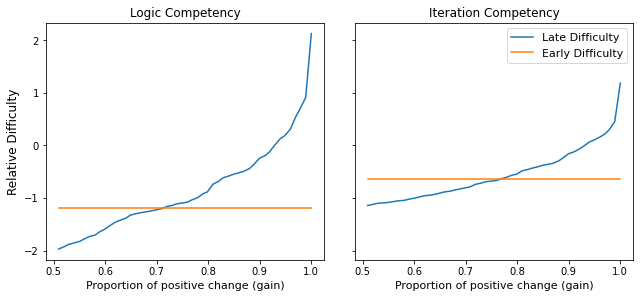

In [132]:
early_reldiff = rel_test_difficulty(A=early_A, delta=early_delta)
shift_table(s_hat=s_hat, A=late_A, delta=late_delta, early_reldiff=early_reldiff)
plt.savefig("results/plots/csedm_reldiff_vs_shift", dpi=250)

In [80]:
rel_test_difficulty(A=early_A, delta=early_delta)

C:\Users\Gerha\AppData\Local\Temp\ipykernel_11312\1158090350.py:2: RuntimeWarning: divide by zero encountered in divide
  rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)


array([-1.19815747, -0.6331392 ])

In [134]:
shift = np.zeros(2)
#Logic shift
shift[0] = -1*np.quantile(s_hat[:,0], q=0.15, axis=0)
#Iteration shift
shift[1] = -1*np.quantile(s_hat[:,1], q=0.05, axis=0)
s_hat_shift = s_hat + shift
mu_shift = late_model.person_parameters["mean"][2:4] + shift
late_delta_shift = late_delta - np.dot(late_A, shift)

In [135]:
#Check shift results
np.divide(np.sum(s_hat_shift >= 0, axis=0), np.sum(s_hat_shift == s_hat_shift, axis=0))

array([0.85013624, 0.94822888])

#### Fit difference Model

In [85]:
# Fit late difference model
late_difference_model = mirt_2pl(latent_dimension=2, item_dimension=V.shape[1], Q=late_Q)
late_difference_model.initialize_from_responses(response_data=V)
e_step_diff = e_step_ga_mml(model=late_difference_model)
m_step_diff = m_step_ga_mml(
    late_difference_model, sigma_constraint="early_constraint")
em_diff = em_algo(e_step=e_step_diff, m_step=m_step_diff, model=late_difference_model)


start_time = time.time()
em_diff.fit([V.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)

estimated_diff_item_parameters = em_diff.model.item_parameters
estimated_diff_person_parameters = em_diff.model.person_parameters

# Estimate early parameters with standard-procedure

# Shift Discriminations and Covariance accoring to real variance
conv_sigma = late_difference_model.person_parameters["covariance"]
conv_A = late_difference_model.item_parameters["discrimination_matrix"]
real_conv_sigma_var = var_logit_late/var_logit_early*np.ones(2)
conv_sd_vector = np.sqrt(real_conv_sigma_var)
conv_sd_matrix = np.diag(conv_sd_vector)
conv_sigma_scaled = np.round(np.dot(
    np.dot(conv_sd_matrix, conv_sigma), conv_sd_matrix), 5)
conv_A_scaled = np.dot(conv_A, np.linalg.inv(conv_sd_matrix).transpose())
scaled_parameters = {"person_parameters": {"covariance": conv_sigma_scaled},
                        "item_parameters": {"discrimination_matrix": conv_A_scaled}}
late_difference_model.set_parameters(scaled_parameters)


#Predict 
late_theta_hat = late_difference_model.predict_competency(
    V, strict_variance=False) + shift
# Double late theta because var(late_theta) = var(early_theta + gain) = var(early_theta) + var(gain) - 2*cov(early_theta, gain)
s_hat_diff = late_theta_hat - theta_hat

EM Iteration 2


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[0.9999 0.4967]
 [0.4967 1.    ]]
Step: 2: current parameter_diff: 6.431710228256767, current marginal loglikelihood: -3470.334968764041
EM Iteration 3


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324


KeyboardInterrupt: 

In [55]:
np.mean(s_hat_diff, axis=0)

array([0.25031249, 0.95644352])

In [56]:
pd.DataFrame(np.concatenate((theta_hat, s_hat), axis=1)).cov()

,0,1,2,3
0,0.663823,0.258745,-0.011701,-0.060073
1,0.258745,0.631272,0.015110,-0.001835
2,-0.011701,0.015110,0.131428,0.143010
3,-0.060073,-0.001835,0.143010,0.258920


In [57]:
conv_A_scaled

array([[0.        , 0.28404248],
       [1.42965521, 0.29420328],
       [1.15350163, 0.        ],
       [1.60502226, 0.94795313],
       [1.42629083, 0.26123654],
       [0.6612715 , 0.44370995],
       [0.96809642, 0.51597438],
       [0.5006261 , 1.02823122],
       [1.33152079, 1.25278255],
       [0.34442147, 0.95588689],
       [1.10463834, 0.82424051],
       [0.38710207, 1.75585048],
       [0.26751935, 1.67573407],
       [0.4887894 , 0.89491133],
       [0.        , 1.16229546],
       [0.26432815, 1.95916286],
       [0.53273588, 1.62045724],
       [0.20048132, 1.42337082],
       [0.        , 1.92445104],
       [0.        , 1.73402049]])

In [58]:
estimated_diff_parameters["item_parameters"]["discrimination_matrix"] = conv_A_scaled
late_delta = late_estimated_parameters["item_parameters"]["intercept_vector"]
translated_delta = late_delta - \
    np.dot(late_estimated_parameters["item_parameters"]
            ["discrimination_matrix"], np.ones(D))
late_estimated_parameters["item_parameters"]["intercept_vector"] = translated_delta
sigma_psi = pd.DataFrame(np.concatenate(
    (early_theta_hat, s_hat), axis=1)).cov().to_numpy()
late_estimated_parameters["person_parameters"]["covariance"] = sigma_psi

######################
item_dimension = parameter_dict["item_dimension"]
actual_late_model = mirt_2pl_gain(item_dimension=item_dimension, latent_dimension=D,
                                    mu=gain_mean,
                                    early_sigma=early_estimated_parameters["person_parameters"]["covariance"],
                                    Q=parameter_dict["real_late_parameters"]["item_parameters"]["q_matrix"])

NameError: name 'estimated_diff_parameters' is not defined

## Report Item Parameters

In [136]:
def item_parameter_table(A, Q, delta, latent_description=["Logic", "Iteration"], caption="", n=367):
    data = pd.DataFrame(np.concatenate((Q, A), axis=1))
    data.columns = pd.MultiIndex.from_product([['Q', 'A'], latent_description],
                                     names=['Param.', 'Latent dim.'])
    delta_df = pd.DataFrame(np.expand_dims(delta, 1), columns=[("$\Delta$", "")])
    data = pd.concat((data, delta_df), axis=1)
    data = np.round(data, 3)
    print(data.to_latex(bold_rows=True, multicolumn=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(data)

In [143]:
item_parameter_table(A=early_A, Q=early_Q, delta=early_delta, caption="CSEDM: Early Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Early Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   1.0 &       0.0 &  0.884 &     0.000 &    1.613 \\
\textbf{1 } &   1.0 &       0.0 &  1.209 &     0.000 &    1.344 \\
\textbf{2 } &   1.0 &       0.0 &  0.917 &     0.000 &    1.308 \\
\textbf{3 } &   1.0 &       0.0 &  0.722 &     0.000 &    1.292 \\
\textbf{4 } &   1.0 &       0.0 &  1.188 &     0.000 &    1.290 \\
\textbf{5 } &   1.0 &       0.0 &  1.439 &     0.000 &    1.445 \\
\textbf{6 } &   1.0 &       0.0 &  1.013 &     0.000 &    1.162 \\
\textbf{7 } &   1.0 &       0.0 &  0.865 &     0.000 &    1.284 \\
\textbf{8 } &   1.0 &       0.0 &  1.016 &     0.000 &    1.148 \\
\textbf{9 } &   1.0 &       0.0 &  1.375 &     0.000 &    1.241 \\
\textbf{10} &   1.0 &       0.0 &  1.182 &     0.00

Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             1.0       0.0  0.884     0.000    1.613
1             1.0       0.0  1.209     0.000    1.344
2             1.0       0.0  0.917     0.000    1.308
3             1.0       0.0  0.722     0.000    1.292
4             1.0       0.0  1.188     0.000    1.290
5             1.0       0.0  1.439     0.000    1.445
6             1.0       0.0  1.013     0.000    1.162
7             1.0       0.0  0.865     0.000    1.284
8             1.0       0.0  1.016     0.000    1.148
9             1.0       0.0  1.375     0.000    1.241
10            1.0       0.0  1.182     0.000    1.416
11            1.0       0.0  1.229     0.000    1.588
12            1.0       0.0  1.140     0.000    1.518
13            1.0       0.0  1.298     0.000    1.398
14            1.0       0.0  1.102     0.000    1.142
15            1.0       0.0  1.239     0.000    0.759
16            1.0       0.0  1.209     0.000    1.201
17            1.0       0.0  1.000     0.000    1.195
18            1.0       1.0  1.201     0.669    0.095
19            1.0       0.0  0.887     0.000    0.596
20            0.0       1.0  0.000     2.438    1.559
21            1.0       1.0  0.073     2.374    1.214
22            1.0       1.0  0.322     1.633    1.075
23            1.0       1.0  0.427     1.627    1.020
24            1.0       1.0  0.968     1.214    1.365
25            1.0       0.0  0.875     0.000    1.066
26            1.0       1.0  0.577     1.105    0.571
27            1.0       1.0  0.869     1.295    1.236
28            1.0       1.0  0.822     1.017    0.991
29            1.0       1.0  0.642     1.828    1.026

In [144]:
item_parameter_table(A=late_A, Q=late_Q, delta=late_delta_shift, caption="CSEDM: Late Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Late Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   0.0 &       1.0 &  0.000 &     0.565 &    0.874 \\
\textbf{1 } &   1.0 &       1.0 &  0.921 &     0.907 &    0.246 \\
\textbf{2 } &   1.0 &       0.0 &  1.297 &     0.000 &    1.334 \\
\textbf{3 } &   1.0 &       1.0 &  0.965 &     1.349 &   -0.182 \\
\textbf{4 } &   1.0 &       1.0 &  1.000 &     0.764 &    0.134 \\
\textbf{5 } &   1.0 &       1.0 &  0.600 &     0.822 &    0.146 \\
\textbf{6 } &   1.0 &       1.0 &  0.960 &     0.756 &    0.007 \\
\textbf{7 } &   1.0 &       1.0 &  0.127 &     1.423 &    0.009 \\
\textbf{8 } &   1.0 &       1.0 &  0.996 &     2.056 &   -0.754 \\
\textbf{9 } &   1.0 &       1.0 &  0.381 &     1.421 &   -0.790 \\
\textbf{10} &   1.0 &       1.0 &  0.995 &     1.238

Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             0.0       1.0  0.000     0.565    0.874
1             1.0       1.0  0.921     0.907    0.246
2             1.0       0.0  1.297     0.000    1.334
3             1.0       1.0  0.965     1.349   -0.182
4             1.0       1.0  1.000     0.764    0.134
5             1.0       1.0  0.600     0.822    0.146
6             1.0       1.0  0.960     0.756    0.007
7             1.0       1.0  0.127     1.423    0.009
8             1.0       1.0  0.996     2.056   -0.754
9             1.0       1.0  0.381     1.421   -0.790
10            1.0       1.0  0.995     1.238    0.020
11            1.0       1.0  0.678     2.132    0.072
12            1.0       1.0  0.447     1.643   -0.414
13            1.0       1.0  0.619     1.252    0.235
14            0.0       1.0  0.000     1.071    0.968
15            1.0       1.0  0.177     2.060   -0.171
16            1.0       1.0  0.464     1.658   -0.748
17            1.0       1.0  0.581     1.074    0.019
18            0.0       1.0  0.000     1.846   -0.197
19            0.0       1.0  0.000     1.493    0.259

(array([[  4.,  16.,  68., 119., 144.,  15.,   1.,   0.,   0.,   0.],
        [  1.,   3.,  30.,  45.,  69.,  96.,  98.,  21.,   1.,   3.]]),
 array([-0.8881526 , -0.54133085, -0.1945091 ,  0.15231265,  0.49913439,
         0.84595614,  1.19277789,  1.53959964,  1.88642138,  2.23324313,
         2.58006488]),
 <a list of 2 BarContainer objects>)

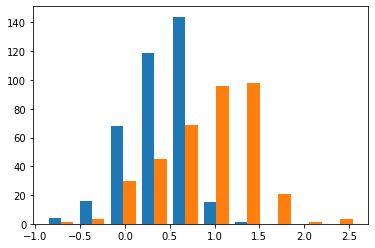

In [139]:
plt.hist(s_hat_shift)

#### Person Parameters

In [140]:
#early
early_covariance = early_model.person_parameters["covariance"]
early_mu = np.zeros(2)

#late
late_covariance = late_model.person_parameters["covariance"]
late_mu = np.concatenate((early_mu, mu_shift), axis=0)

In [141]:
def table_person_parameters(covariance, mu, latent_description=["Logic", "Iteration"], caption="", n=367):
    cov_df = pd.DataFrame(covariance)
    index = pd.MultiIndex.from_product([['Prior Competence', 'Competence Gain'], latent_description],
                        names=['Param.', 'Latent dim.'])
    cov_df.columns = index
    mu_df = pd.DataFrame(np.expand_dims(mu, axis=1), columns=[("Mean", "")])
    person_df = pd.concat((cov_df, mu_df), axis=1)
    person_df.index = index
    person_df = np.round(person_df, 3)
    print(person_df.to_latex(bold_rows=True, multicolumn=True, 
                                caption=caption+", n={0}".format(n), 
                                position="H", escape=False))
    return(person_df)
    

In [142]:
table_person_parameters(covariance=late_covariance, mu=late_mu, caption="CSEDM: Person Parameters")
# TODO: Evtl. Korrelationsmatrix mit Varianz-Spalte

\begin{table}[H]
\centering
\caption{CSEDM: Person Parameters, n=367}
\begin{tabular}{llrrrrr}
\toprule
                & \textbf{Param.} & \multicolumn{2}{l}{Prior Competence} & \multicolumn{2}{l}{Competence Gain} &   Mean \\
                & \textbf{Latent dim.} &            Logic & Iteration &           Logic & \multicolumn{2}{l}{Iteration} \\
\textbf{Param.} & \textbf{Latent dim.} &                  &           &                 &           &        \\
\midrule
\textbf{Prior Competence} & \textbf{Logic} &            1.000 &     0.264 &           0.133 &     0.068 &  0.000 \\
                & \textbf{Iteration} &            0.264 &     1.000 &           0.066 &     0.138 &  0.000 \\
\textbf{Competence Gain} & \textbf{Logic} &            0.133 &     0.066 &           0.354 &     0.092 &  0.368 \\
                & \textbf{Iteration} &            0.068 &     0.138 &           0.092 &     0.342 &  0.893 \\
\bottomrule
\end{tabular}
\end{table}



Param.                       Prior Competence           Competence Gain  \
Latent dim.                             Logic Iteration           Logic   
Param.           Latent dim.                                              
Prior Competence Logic                  1.000     0.264           0.133   
                 Iteration              0.264     1.000           0.066   
Competence Gain  Logic                  0.133     0.066           0.354   
                 Iteration              0.068     0.138           0.092   

Param.                                   Mean  
Latent dim.                  Iteration         
Param.           Latent dim.                   
Prior Competence Logic           0.068  0.000  
                 Iteration       0.138  0.000  
Competence Gain  Logic           0.092  0.368  
                 Iteration       0.342  0.893

#### Gain Visualization

In [145]:
def quantile_mean(df, metric, quantiles=[0.25, 0.5, 0.75, 1]):
    mean_df = pd.DataFrame()
    metric_quantiles = np.quantile(df[metric], quantiles)
    for quantile in metric_quantiles:
        quantile_df = df[df[metric] < quantile]
        df = df[df[metric] >= quantile]
        mean_df = pd.concat((mean_df, pd.DataFrame(quantile_df.mean()).transpose()), axis=0)
    mean_df.index = quantiles
    return(mean_df)

In [146]:
latent_df_csedm = pd.DataFrame(np.concatenate((theta_hat, s_hat_shift), axis=1))
latent_df_csedm.columns = ["prior logic", "prior iter", "logic gain", "iter gain"]

In [147]:
logic_quantile_mean = quantile_mean(latent_df_csedm, metric="prior logic")
logic_quantile_mean["post logic"] = logic_quantile_mean["prior logic"] + logic_quantile_mean["logic gain"]
logic_quantile_mean["post iter"] = logic_quantile_mean["prior iter"] + logic_quantile_mean["iter gain"]
np.round(logic_quantile_mean, 2)

,prior logic,prior iter,logic gain,iter gain,post logic,post iter
0.25,-0.93,-0.22,0.42,1.01,-0.51,0.80
0.50,-0.18,-0.06,0.35,0.84,0.16,0.78
0.75,0.35,-0.00,0.38,0.86,0.73,0.86
1.00,1.11,0.42,0.44,0.94,1.55,1.36


In [148]:
logic_quantiles = np.quantile(theta_hat[:,0], [0.25, 0.5, 0.75, 1], axis=0)
iter_quantiles = np.quantile(theta_hat[:,1], [0.25, 0.5, 0.75, 1], axis=0)

In [149]:
theta_logic_quantiles = np.split(theta_hat[np.argsort(theta_hat[:,0]), :], [10, 20])

## Test Set prediction

In [46]:
TEST_PATH = os.path.join("C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset/F19_Release_Test_06-28-21/test")

test_ps2 = ProgSnap2Dataset(os.path.join(TEST_PATH, 'Data'))
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))

#test_subject_df = make_subject_df(early_test)
#test_subject_df = test_subject_df.drop("PercAltLabelTrue", 1)

#Obtain Matrix of Response-vectors
test_U = pd.crosstab(index = early_test["SubjectID"], 
            columns=[early_test["AssignmentID"], early_test["ProblemID"]], 
            values=early_test["Label"],
            aggfunc="sum")